This solution accelerator notebook is available at [Databricks Industry Solutions](https://github.com/databricks-industry-solutions/supply-chain-stress-test).

# Stress-Test Large Networks and Analyze the Results

This notebook demonstrates how to perform stress testing on a large supply chain network. While the previous notebooks focused on a small network (35 nodes), modern supply chains often consist of tens of thousands of suppliers and sub-suppliers. To run comprehensive stress tests on such large-scale networks, a scalable setup is essential. We leverage distributed computation using [Ray on Databricks](https://docs.databricks.com/aws/en/machine-learning/ray/) to achieve this. This notebook covers network generation (1,700 nodes), Ray cluster setup, distributed optimization, and result analysis.


## Cluster Configuration
This notebook was tested on the following Databricks cluster configuration:
- **Databricks Runtime Version:** 16.4 LTS ML (includes Apache Spark 3.5.2, Scala 2.12)
- **Driver Type** 
    - Azure: Standard_DS4_v2 (28 GB Memory, 8 Cores)
    - AWS: m5d.2xlarge (32 GB Memory, 8 Cores)
- **Worker Type** 
    - Azure: Standard_E4d_v4 (32 GB Memory, 4 Cores)
    - AWS: rd-fleet.xlarge (32 GB Memory, 4 Cores)
- **Number of Workers:** 4
- **Photon Acceleration:** Disabled (Photon boosts Apache Spark workloads; not all ML workloads will see an improvement)
> **Note:** Performance may vary depending on the cluster size, node types, and workload characteristics. For large-scale distributed computation, ensure sufficient resources are allocated to avoid bottlenecks.

In [0]:
%pip install -r ./requirements.txt --quiet
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import os
import random
import numpy as np
import pandas as pd
import pyomo.environ as pyo
from pyomo.common.timing import TicTocTimer
import scripts.utils as utils

We will write the results of our optimization to Delta tables. Update the `catalog` and `schema` names below to specify where you want the results to be saved.

In [0]:
catalog = "supply_chain_stress_test" # Change here
schema = "results"                   # Change here

# Make sure that the catalog and the schema exist
_ = spark.sql(f"CREATE CATALOG IF NOT EXISTS {catalog}") 
_ = spark.sql(f"CREATE SCHEMA IF NOT EXISTS {catalog}.{schema}") 

## Generate Data
We generate a synthetic 3-tier supply chain network dataset for optimization. We also assign random time-to-recovery (ttr) values to each disrupted node.

In [0]:
# Generate a synthetic 3-tier network dataset for optimization 
dataset = utils.generate_data(N1=200, N2=500, N3=1000) # DO NOT CHANGE!

# Assign a random ttr (time-to-recovery) to each disrupted node
random.seed(777) # DO NOT CHANGE!
disrupted_nodes = {node: random.randint(1, 10) for node in dataset['tier2'] + dataset['tier3']}

## Retrieve Databricks Cluster Information
This function retrieves the minimum and maximum number of worker nodes from the Databricks cluster context using the REST API. This information is used to configure the Ray cluster for distributed computation.

In [0]:
# Databricks-only: get cluster context and min/max nodes
def get_min_max_nodes():
    try:
        import requests
        ctx = dbutils.notebook.entry_point.getDbutils().notebook().getContext()
        host_name = ctx.browserHostName().get()
        host_token = ctx.apiToken().get()
        cluster_id = ctx.clusterId().get()
        response = requests.get(
            f'https://{host_name}/api/2.1/clusters/get?cluster_id={cluster_id}',
            headers={'Authorization': f'Bearer {host_token}'}
        ).json()
        if "autoscale" in response:
            return response['autoscale']["min_workers"], response['autoscale']["max_workers"]
    except Exception as e:
        
        print(f"Warning: Could not fetch min/max nodes from Databricks context: {e}")

    return 1, response['num_workers']  # fallback for local/testing

min_node, max_node = get_min_max_nodes()

## Ray Cluster Initialization
Ray is a distributed execution framework that enables scalable parallel computation. Here, we initialize a Ray cluster on Databricks using the `setup_ray_cluster` utility. The number of worker nodes and CPU cores per node are set based on the Databricks cluster configuration. Environment variables for Databricks authentication are also set for Ray workers.

In [0]:
import ray
from ray.util.spark import setup_ray_cluster, shutdown_ray_cluster

# Cluster cleanup: shut down any existing Ray cluster and Ray context to ensure a clean start
restart = True
if restart is True:
    try:
        shutdown_ray_cluster()
    except Exception:
        pass
    try:
        ray.shutdown()
    except Exception:
        pass

# Set configs based on your cluster size
num_cpu_cores_per_worker = 4 # total cpu to use in each worker node 
num_cpus_head_node = 4 # Cores to use in driver node (total_cores - 4)

# Set databricks credentials as env vars for Ray workers
try:
    from mlflow.utils.databricks_utils import get_databricks_env_vars
    mlflow_dbrx_creds = get_databricks_env_vars("databricks")
    os.environ["DATABRICKS_HOST"] = mlflow_dbrx_creds['DATABRICKS_HOST']
    os.environ["DATABRICKS_TOKEN"] = mlflow_dbrx_creds['DATABRICKS_TOKEN']
except Exception as e:
    print(f"Warning: Could not set Databricks env vars: {e}")

# Start the Ray cluster with the specified configuration
ray_conf = setup_ray_cluster(
    min_worker_nodes=min_node,
    max_worker_nodes=max_node,
    num_cpus_head_node=num_cpus_head_node,
    num_cpus_per_node=num_cpu_cores_per_worker,
    num_gpus_head_node=0,
    num_gpus_worker_node=0
)
os.environ['RAY_ADDRESS'] = ray_conf[0]

In each spark worker node, we recommend making the sum of 'spark_executor_memory + num_Ray_worker_nodes_per_spark_worker * (memory_worker_node + object_store_memory_worker_node)' to be less than 'spark_worker_physical_memory * 0.8', otherwise it might lead to spark worker physical memory exhaustion and Ray task OOM errors.

2025-06-21 05:41:08,999	INFO cluster_init.py:545 -- Ray head hostname: 10.0.19.25, port: 9867, ray client server port: 9698.


2025-06-21 05:41:12,351	INFO usage_lib.py:467 -- Usage stats collection is enabled by default without user confirmation because this terminal is detected to be non-interactive. To disable this, add `--disable-usage-stats` to the command that starts the cluster, or run the following command: `ray disable-usage-stats` before starting the cluster. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.
2025-06-21 05:41:12,351	INFO scripts.py:778 -- Local node IP: 10.0.19.25
2025-06-21 05:41:13,978	SUCC scripts.py:815 -- --------------------
2025-06-21 05:41:13,978	SUCC scripts.py:816 -- Ray runtime started.
2025-06-21 05:41:13,978	SUCC scripts.py:817 -- --------------------
2025-06-21 05:41:13,978	INFO scripts.py:819 -- Next steps
2025-06-21 05:41:13,978	INFO scripts.py:822 -- To add another node to this Ray cluster, run
2025-06-21 05:41:13,978	INFO scripts.py:825 --   ray start --address='10.0.19.25:9867'
2025-06-21 05:41:13,978	INFO scripts.py:834 -- To connect to t

2025-06-21 05:41:29,024	INFO cluster_init.py:667 -- Ray head node started.
2025-06-21 05:41:29,026	INFO databricks_hook.py:129 -- The Ray cluster will be shut down automatically if you don't run commands on the Databricks notebook for 30.0 minutes. You can change the auto-shutdown minutes by setting 'DATABRICKS_RAY_ON_SPARK_AUTOSHUTDOWN_MINUTES' environment variable, setting it to 0 means that the Ray cluster keeps running until you manually call `ray.util.spark.shutdown_ray_cluster()` or detach Databricks notebook.
2025-06-21 05:41:29,031	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.19.25:9867...
2025-06-21 05:41:29,039	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at http://10.0.19.25:9845 


To monitor and debug Ray from Databricks, view the dashboard at 
 https://dbc-dp-1444828305810485.cloud.databricks.com/driver-proxy/o/1444828305810485/0611-040353-lvzztkjv/9845/


Open Ray Cluster Dashboard in a new tab

2025-06-21 05:41:32,659	INFO cluster_init.py:167 -- Started 1 Ray worker nodes, meet the minimum number of Ray worker nodes required.


## Prepare Data for Distributed Computation
Here, we convert the disrupted nodes dictionary we defined above to a pandas DataFrame, then to a Ray Dataset for distributed processing.

In [0]:
df = pd.DataFrame.from_dict(disrupted_nodes, orient='index', columns=['ttr']).reset_index(names='node')
df = ray.data.from_pandas(df)

2025-06-21 05:41:34,694	INFO worker.py:1461 -- Using address 10.0.19.25:9867 set in the environment variable RAY_ADDRESS
2025-06-21 05:41:34,695	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.19.25:9867...
2025-06-21 05:41:34,701	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at http://10.0.19.25:9845 


## Multi-Tier TTR Model

### Define the Solver Class
The `TTRSolver` class encapsulates the logic for running the `utils.build_and_solve_multi_tier_ttr` function for each disrupted scenario. It is designed to be used with Ray's [distributed map](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map.html) operation.

In [0]:
class TTRSolver:
    """
    Callable class to run the Pyomo model for a single disrupted scenario.
    """
    
    def __init__(self, data=dataset):
        self.data = dataset

    def __call__(self, row):
        """Run the Pyomo model for a single disrupted scenario."""
        disrupted = [row['node']]
        # Call the utility function to build and solve the optimization model
        solver = utils.build_and_solve_multi_tier_ttr(self.data, disrupted, row['ttr'])
        row['termination_condition'] = str(solver.iloc[0]['termination_condition'])
        row['lost_profit'] = solver.iloc[0]['lost_profit']
        return row

### Test the Solver on a Single Row
This cell tests the `TTRSolver` class on a single row to ensure correctness before distributed execution.

In [0]:
TTRSolver()(df.take(1)[0])

2025-06-21 05:41:36,775	INFO dataset.py:2416 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-06-21 05:41:36,779	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /local_disk0/tmp/ray-9867-212e16f1/session_2025-06-21_05-41-12_351987_1581/logs/ray-data
2025-06-21 05:41:36,780	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- limit=1 1: 0.00 row [00:00, ? row/s]

{'node': 'T2_1',
 'ttr': 4,
 'termination_condition': 'optimal',
 'lost_profit': 0.0}

### Distributed Computation with Ray Data API
The following cell demonstrates distributed computation using [Ray's Data API](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map.html):
- The Ray Dataset is repartitioned into 300 partitions to increase parallelism and optimize resource utilization across the cluster.
- The `map` function applies the `TTRSolver` class to each partition in parallel, with each task using 1 CPU and a concurrency window of (4, 20) you can adjust the concurreny based on your cluster setup.
- The results are collected as a pandas DataFrame for further analysis.

**The following cell will run in about a minute. On a single-node cluster without distributed computation, the same calculation would take approximately an hour to complete.**

In [0]:
df_ttr = df.repartition(300).map(TTRSolver,
       num_cpus=1,
       concurrency=(4,20))
pandas_df_ttr = df_ttr.to_pandas()

2025-06-21 05:41:37,479	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /local_disk0/tmp/ray-9867-212e16f1/session_2025-06-21_05-41-12_351987_1581/logs/ray-data
2025-06-21 05:41:37,480	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> ActorPoolMapOperator[Map(TTRSolver)]


Running 0: 0.00 row [00:00, ? row/s]

- Repartition 1: 0.00 row [00:00, ? row/s]

Split Repartition 2:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Map(TTRSolver) 3: 0.00 row [00:00, ? row/s]

2025-06-21 05:41:44,349	WARNING progress_bar.py:122 -- Truncating long operator name to 100 characters.To disable this behavior, set `ray.data.DataContext.get_current().DEFAULT_ENABLE_PROGRESS_BAR_NAME_TRUNCATION = False`.


(autoscaler +50s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +50s) Adding 3 node(s) of type ray.worker.
(autoscaler +54s) Resized to 12 CPUs.
(autoscaler +1m0s) Resized to 16 CPUs.
(autoscaler +1m3s) Resized to 20 CPUs.


### Highest Risk Nodes
Let's examine the top 10 nodes with the highest lost profit.

In [0]:
highest_risk_nodes = pandas_df_ttr.sort_values(by="lost_profit", ascending=False)[0:10]
display(highest_risk_nodes)

node,ttr,termination_condition,lost_profit
T2_25,10,optimal,4918.12
T3_397,10,optimal,3861.44
T2_347,10,optimal,3737.6600000000003
T2_183,10,optimal,3653.9900000000002
T2_370,10,optimal,3615.9
T2_14,10,optimal,3340.9
T2_199,9,optimal,3280.9000000000005
T3_230,10,optimal,3262.96
T3_578,9,optimal,3193.44
T2_450,9,optimal,3109.03


### Total Spend vs. Lost Profit

Let's imagine we have a global budget for risk mitigation in our supply chain, and each node receives some portion of that budget. The purpose of this analysis is to identify which nodes are over- or under-invested based on the risk exposure we previously computed. For simplicity, we randomly assign the total spend on risk mitigation measures for each node.


In [0]:
np.random.seed(42) # DO NOT CHANGE!
pandas_df_ttr["total_spend"] = np.abs(np.random.normal(loc=0, scale=50, size=len(pandas_df_ttr))).astype(int)

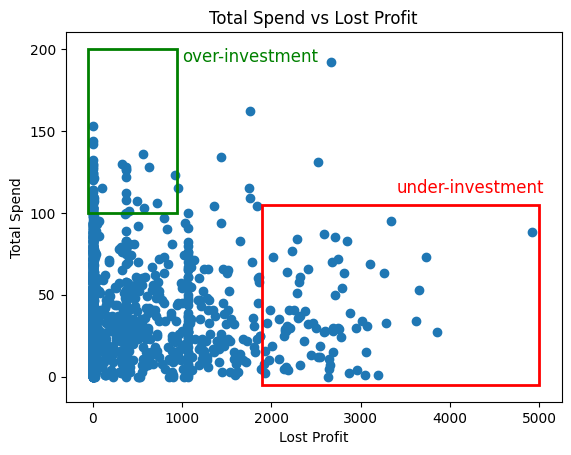

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.scatter(pandas_df_ttr["lost_profit"], pandas_df_ttr["total_spend"])
plt.xlabel("Lost Profit")
plt.ylabel("Total Spend")
plt.title("Total Spend vs Lost Profit")

rect_1 = patches.Rectangle((1900, -5), 3100, 110, linewidth=2, edgecolor='red', facecolor='none')
rect_2 = patches.Rectangle((-50, 100), 1000, 100, linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(rect_1)
plt.gca().add_patch(rect_2)

plt.text(1000, 195, "over-investment", color='green', fontsize=12, verticalalignment='center')
plt.text(3400, 115, "under-investment", color='red', fontsize=12, verticalalignment='center')

plt.show()

The scatter plot above shows total spend on supplier sites for risk mitigation on the vertical axis and lost profit on the horizontal axis. This visualization helps quickly identify areas where risk mitigation investment is undersized relative to the potential impact of a node failure (right box), as well as areas where investment may be oversized relative to the risk (left box and potentially all nodes with zero lost profit). Both regions highlight opportunities to reassess and optimize the investment strategy—either to strengthen network resiliency or reduce unnecessary costs.

## Multi-Tier TTS Model

### Define the Solver Class
The `TTSSolver` class encapsulates the logic for running the `utils.build_and_solve_multi_tier_tts` function for each disruption scenario. It will reuse the same Ray cluster defined above.


In [0]:
class TTSSolver:
    """
    Callable class to run the Pyomo model for a single disrupted scenario.
    """
    
    def __init__(self, data=dataset):
        self.data = dataset

    def __call__(self, row):
        """Run the Pyomo model for a single disrupted scenario."""
        disrupted = [row['node']]
        # Call the utility function to build and solve the optimization model
        solver = utils.build_and_solve_multi_tier_tts(self.data, disrupted)
        row['termination_condition'] = str(solver.iloc[0]['termination_condition'])
        row['tts'] = solver.iloc[0]['tts']
        return row

### Test the Solver on a Single Row
This cell tests the `TTSSolver` class on a single row to ensure correctness before distributed execution.

In [0]:
TTSSolver()(df.take(1)[0])

2025-06-21 05:42:53,466	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /local_disk0/tmp/ray-9867-212e16f1/session_2025-06-21_05-41-12_351987_1581/logs/ray-data
2025-06-21 05:42:53,467	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- limit=1 1: 0.00 row [00:00, ? row/s]

{'node': 'T2_1',
 'ttr': 4,
 'termination_condition': 'optimal',
 'tts': 5.288461538461538}

### Run the Solver at Scale

Let's solve the TTS model at scale. The following cell will run for approximately 30 minutes using the cluster configuration mentioned above.

In [0]:
df_tts = df.repartition(300).map(TTSSolver,
                                 num_cpus=1,
                                 concurrency=(4,20))
pandas_df_tts = df_tts.to_pandas()

2025-06-21 05:42:55,671	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /local_disk0/tmp/ray-9867-212e16f1/session_2025-06-21_05-41-12_351987_1581/logs/ray-data
2025-06-21 05:42:55,672	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> ActorPoolMapOperator[Map(TTSSolver)]


Running 0: 0.00 row [00:00, ? row/s]

- Repartition 1: 0.00 row [00:00, ? row/s]

Split Repartition 2:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Map(TTSSolver) 3: 0.00 row [00:00, ? row/s]

2025-06-21 06:08:56,607	WARNING spark_job_server.py:73 -- Spark job ray-cluster-9867-212e16f1-worker-node-3 hosting Ray worker node exit.


(autoscaler +28m1s) Removing 1 nodes of type ray.worker (idle).
(autoscaler +28m3s) Resized to 16 CPUs.


2025-06-21 06:13:27,812	WARNING spark_job_server.py:73 -- Spark job ray-cluster-9867-212e16f1-worker-node-2 hosting Ray worker node exit.


(autoscaler +32m32s) Removing 1 nodes of type ray.worker (idle).
(autoscaler +32m34s) Resized to 12 CPUs.


2025-06-21 06:14:29,404	WARNING spark_job_server.py:73 -- Spark job ray-cluster-9867-212e16f1-worker-node-4 hosting Ray worker node exit.


(autoscaler +33m34s) Removing 1 nodes of type ray.worker (idle).
(autoscaler +33m36s) Resized to 8 CPUs.


### Analyze Results

array([[<Axes: title={'center': 'Histogram of TTR - TTS'}, xlabel='TTR - TTS', ylabel='Frequency'>]],
      dtype=object)

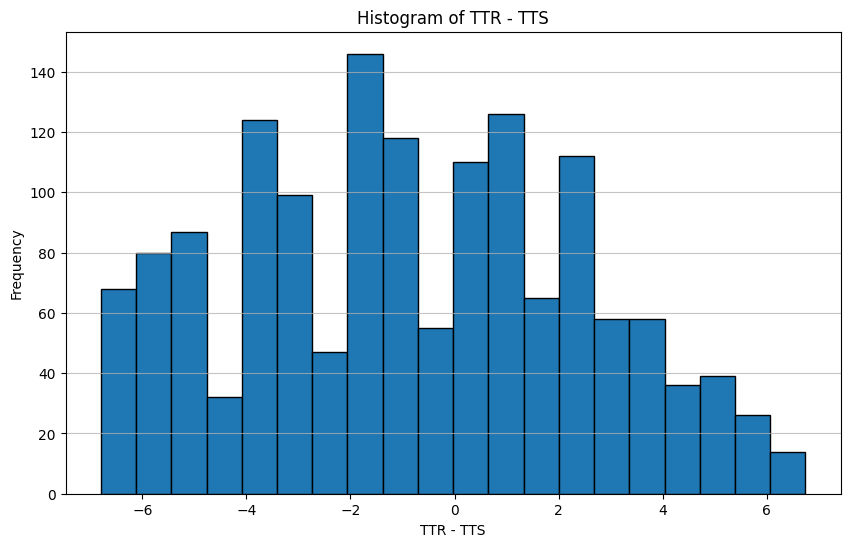

In [0]:
import matplotlib.pyplot as plt

pandas_df_tts['delta'] = pandas_df_tts['ttr'] - pandas_df_tts['tts']
ax = pandas_df_tts.hist(column='delta', bins=20, grid=False, edgecolor='black', figsize=(10, 6))
plt.title('Histogram of TTR - TTS')
plt.xlabel('TTR - TTS')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
display(ax)

Note that TTS represents the maximum amount of time the network can operate without performance loss when a specific node is disrupted. It becomes particularly important when a node’s TTR exceeds its TTS.

Refer to the histogram above, which shows the distribution of differences between TTR and TTS for each node. Nodes with a negative TTR − TTS are generally not a concern—assuming the provided TTR values are accurate. However, nodes with a positive TTR − TTS may incur financial loss, especially those with a large gap.

To enhance network resiliency, companies can engage in discussions with their suppliers to reduce TTR, increase TTS or explore alternative sourcing and diversification strategies.

## Shutdown Ray Cluster

In [0]:
try:
    shutdown_ray_cluster()
except Exception:
    pass
try:
    ray.shutdown()
except Exception:
    pass

2025-06-21 06:19:59,646	WARNING spark_job_server.py:73 -- Spark job ray-cluster-9867-212e16f1-worker-node-1 hosting Ray worker node exit.


## Write to Delta Tables

In [0]:
# Databricks-only: save to Delta table
try:
    spark.createDataFrame(pandas_df_ttr).write.mode("overwrite").saveAsTable(f"{catalog}.{schema}.stress_test_result_ttr")
except Exception as e:
    print(f"Warning: Could not save to Delta table: {e}")

try:
    spark.createDataFrame(pandas_df_tts).write.mode("overwrite").saveAsTable(f"{catalog}.{schema}.stress_test_result_tts")
except Exception as e:
    print(f"Warning: Could not save to Delta table: {e}")

## Wrap Up

In this notebook, we explored how to perform stress testing on a large supply chain network. We leveraged Ray on Databricks to distribute the simulation of thousands of disruption scenarios. We then analyzed the distribution of risk exposures across these scenarios and identified nodes that may require additional investment, as well as those that may have been previously over-invested.

This concludes the main part of the solution accelerator. The next notebook, `04_appendix`, is optional. It dives into the mathematical formulation of the optimization problem and discusses key assumptions.


&copy; 2025 Databricks, Inc. All rights reserved. The source in this notebook is provided subject to the Databricks License [https://databricks.com/db-license-source].  All included or referenced third party libraries are subject to the licenses set forth below.

| library                                | description             | license    | source                                              |
|----------------------------------------|-------------------------|------------|-----------------------------------------------------|
| pyomo | An object-oriented algebraic modeling language in Python for structured optimization problems | BSD-3 | https://pypi.org/project/pyomo/
| highspy | Linear optimization solver (HiGHS) | MIT | https://pypi.org/project/highspy/
| ray | Framework for scaling AI/Python applications | Apache 2.0 | https://github.com/ray-project/ray